In [12]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import *
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

In [13]:
train = pd.read_csv('data/train.csv')
train_label=pd.read_csv('data/train_target.csv')
train=train.merge(train_label,on='id')
test= pd.read_csv('data/test.csv')

In [14]:
train.head()

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,certValidBegin,certBalidStop,bankCard,ethnic,residentAddr,highestEdu,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,target
0,83440,541203,2,2,28,541203,0,16,9.467,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4,6,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,3666470400,4.297622e+09,623668159.0,0,841203,-999,1,11,6,1,1,1,0,0,0
1,2732,713322,1,1,33,710100,0,2,1.963,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,3769804800,4.400957e+09,NaN,0,1010114,-999,0,23,6,0,0,0,0,0,0
2,72725,560727,2,2,27,560727,0,16,3.667,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,3637353600,3.952973e+09,621700323.0,0,-999,-999,11,18,2,1,1,1,0,0,0
3,34372,352103,2,1,46,352100,0,16,4.433,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,5,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3417638400,4.048790e+09,622848101.0,0,-999,-999,2,7,1,0,0,1,0,0,0
4,4701,572901,2,2,30,572900,0,16,5.567,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,3680294400,4.311446e+09,621700230.0,0,871702,-999,1,10,6,0,0,0,0,0,0


基本数据描述

In [15]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Unique_values', ascending=False)[:20]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,id,56411,0.000000,0.001773,int64
91,certBalidStop,6224,0.000000,0.333268,float64
92,bankCard,4769,23.679779,23.679779,float64
90,certValidBegin,4620,0.000000,0.186134,int64
1,certId,3696,0.000000,0.716172,int64
5,dist,3237,0.000000,1.024623,int64
94,residentAddr,2694,0.000000,54.218149,int64
8,lmt,1108,0.000000,2.802645,float64
93,ethnic,46,0.000000,92.226693,int64
4,age,37,0.000000,6.906454,int64


In [16]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Unique_values', ascending=False)[:20]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,id,27785,0.000000,0.003599,int64
91,certBalidStop,5504,0.000000,0.399496,float64
90,certValidBegin,4094,0.000000,0.197949,int64
92,bankCard,3607,24.452042,24.452042,float64
1,certId,3361,0.000000,0.755803,int64
5,dist,2857,0.000000,0.906964,int64
94,residentAddr,2391,0.000000,53.503689,int64
8,lmt,946,0.000000,2.695699,float64
93,ethnic,45,0.000000,92.485154,int64
4,age,36,0.000000,6.928199,int64


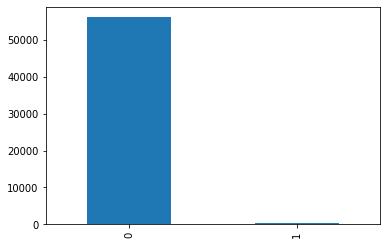

In [17]:
train['target'].value_counts().plot(kind='bar')

特征工程

In [18]:
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [19]:
numerical_columns = ['certBalidStop','certValidBegin','bankCard','certId','dist','residentAddr','lmt']
categorical_columns = [f for f in data.columns if f not in numerical_columns+['id']]

In [20]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(56411, 105)
(27785, 105)


In [21]:
#train['target'] = list(target) 
# train['intTarget'] = pd.cut(train['target'], 5, labels=False)
# train = pd.get_dummies(train, columns=['intTarget'])
# li = ['intTarget_0','intTarget_4']
# mean_columns = []
# for f1 in categorical_columns:
#     cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
#     if cate_rate < 0.90:
#         for f2 in li:
#             col_name = 'B14_to_'+f1+"_"+f2+'_mean'
#             mean_columns.append(col_name)
#             order_label = train.groupby([f1])[f2].mean()
#             train[col_name] = train['B14'].map(order_label)
#             miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
#             if miss_rate > 0:
#                 train = train.drop([col_name], axis=1)
#                 mean_columns.remove(col_name)
#             else:
#                 test[col_name] = test['B14'].map(order_label)
                
# train.drop(li+['target'], axis=1, inplace=True)
# print(train.shape)
# print(test.shape)

In [23]:
X_train = train[categorical_columns+numerical_columns].values
X_test = test[categorical_columns+numerical_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(56411, 494)
(27785, 494)


In [26]:
target=train['target']
y_train =target.values

模型训练

In [47]:
# lgb
# param = {'learning_rate': 0.01,
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'auc',
#         'num_leaves': 256,
#         'feature_fraction': 0.8,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'seed': 1,
#         'bagging_seed': 1,
#         'feature_fraction_seed': 7,
#         'min_data_in_leaf': 20,
#         'nthread': -1,
#         'verbose': -1}
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': 4,
        'min_child_weight': 6,
        'num_leaves': 400,
        'learning_rate': 0.02,# 0.05
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        #'lambda_l1':0.25,
        #'lambda_l2':0.5,
        #'scale_pos_weight':10.0/1.0, #14309.0 / 691.0, #不设置
        #'num_threads':4,
    }
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=10, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(roc_auc_score(list(target),list(oof_lgb))))

fold n°1
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 1	valid_1's auc: 1
[20]	training's auc: 1	valid_1's auc: 1
[30]	training's auc: 1	valid_1's auc: 1
[40]	training's auc: 1	valid_1's auc: 1
[50]	training's auc: 1	valid_1's auc: 1
[60]	training's auc: 1	valid_1's auc: 1
[70]	training's auc: 1	valid_1's auc: 1
[80]	training's auc: 1	valid_1's auc: 1
[90]	training's auc: 1	valid_1's auc: 1
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
fold n°2
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 1	valid_1's auc: 1
[20]	training's auc: 1	valid_1's auc: 1
[30]	training's auc: 1	valid_1's auc: 1
[40]	training's auc: 1	valid_1's auc: 1
[50]	training's auc: 1	valid_1's auc: 1
[60]	training's auc: 1	valid_1's auc: 1
[70]	training's auc: 1	valid_1's auc: 1
[80]	training's auc: 1	valid_1's auc: 1
[90]	training's auc: 1	valid_1's auc: 1
[100]	training's auc:

In [30]:
test['probability']=predictions_lgb
test[['id','probability']].to_csv('base.csv',index=None)

[0, 1]